In [1]:
# ==============================================================================
# 0. BIBLIOTEKŲ IMPORTAVIMAS IR PRADINĖS KONFIGŪRACIJOS
# Šiame bloke importuojamos visos reikalingos bibliotekos projektui.
# ==============================================================================
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# 1. KONFIGŪRACIJA IR DUOMENŲ KELIAI
# Čia nustatomi pagrindiniai projekto parametrai ir keliai iki duomenų failų.
# ==============================================================================

# --- Duomenų keliai ---
DATA_DIR = 'data'
MODEL_DIR = 'models'

CSV_FILE_PATH = os.path.join(DATA_DIR, 'training_solutions_rev1.csv')
IMAGES_DIR_PATH = os.path.join(DATA_DIR, 'images_training_rev1')

# --- Modelio ir Mokymo Parametrai ---
# NUM_IMAGES_TO_USE: Kiek nuotraukų naudoti. Nustatyta naudoti visas.
NUM_IMAGES_TO_USE = None # Arba None, jei norite, kad skaičiuotų automatiškai iš CSV.
# IMG_WIDTH, IMG_HEIGHT: Nuotraukų matmenys. Pakeista į 224x224.
# Didesnė rezoliucija gali padėti modeliui atpažinti smulkesnius bruožus, bet reikalauja daugiau resursų.
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 24 

EPOCHS = 20
LEARNING_RATE = 1e-4
VAL_SPLIT_SIZE = 0.2
TEST_SPLIT_SIZE = 0.2
RANDOM_STATE = 42
MAX_CLASS_WEIGHT = 50.0 # Paliekame, nes kitos klasės vis dar gali būti nesubalansuotos.


# --- Tikslinės Klasės ---
# "Peculiar" klasė sujungiama su "Irregular" siekiant supaprastinti problemą
# ir pagerinti modelio gebėjimą atpažinti likusias klases.
TARGET_CLASSES = ['Elliptical', 'Spiral', 'Edge-on', 'Irregular'] # Pašalinta 'Peculiar'

# --- Modelio Kontrolinio Taško Keliai ---
MODEL_CHECKPOINT_PATH = os.path.join(MODEL_DIR, 'best_galaxy_classifier_initial_224px_4class_balanced.keras')
FINE_TUNED_MODEL_CHECKPOINT_PATH = os.path.join(MODEL_DIR, 'best_galaxy_classifier_finetuned_224px_4class_balanced.keras')



# --- Galaktikų Klasifikavimo Logikos Slenksčiai ---
# Šie slenksčiai naudojami funkcijoje `assign_galaxy_label` norint priskirti galaktikai tipą
# remiantis Galaxy Zoo vartotojų pateiktomis tikimybėmis įvairiems morfologiniams klausimams.
# Kiekvienas slenkstis nurodo minimalią tikimybę arba santykį tam tikram bruožui,
# kad galaktika būtų priskirta atitinkamai klasei.
GALAXY_TYPE_THRESHOLDS = {
    # 'artifact_confidence': Minimali tikimybė (iš Class1.3 stulpelio CSV faile),
    # kad objektas būtų laikomas artefaktu (pvz., žvaigždė, kosminis spindulys).
    #   - DIDINANT šią reikšmę: Mažiau objektų bus klasifikuojama kaip 'Artifact'. Daugiau objektų pereis į tolimesnius
    #                          tikrinimus ir potencialiai bus priskirti galaktikų klasėms. Gali padidėti "triukšmo" kiekis galaktikų klasėse.
    #   - MAŽINANT šią reikšmę: Daugiau objektų bus klasifikuojama kaip 'Artifact'. Mažiau objektų bus laikomi galaktikomis.
    #                          Gali padėti išfiltruoti daugiau netikrų objektų, bet rizikuojama prarasti tikras, neaiškias galaktikas.
    'artifact_confidence': 0.75,

    # 'smooth_min_confidence': Minimali tikimybė (iš Class1.1 stulpelio), kad galaktika būtų laikoma "lygia" (smooth),
    # kas yra pagrindinis bruožas elipsinėms galaktikoms.
    #   - DIDINANT: Reikės didesnio vartotojų sutarimo, kad galaktika lygi. Mažiau galaktikų bus priskirta 'Elliptical' klasei
    #                (ypač jei jos yra ties riba). Daugiau jų gali pereiti į 'Irregular' ar kitas klases.
    #   - MAŽINANT: Net ir esant mažesniam sutarimui, galaktika gali būti laikoma lygia. Daugiau galaktikų bus
    #                priskirta 'Elliptical' klasei. Gali padidėti rizika, kad šiek tiek bruožų turinčios galaktikos bus klaidingai pažymėtos kaip elipsinės.
    'smooth_min_confidence': 0.65,

    # 'smooth_vs_features_ratio': Santykis, nurodantis, kiek kartų "lygios" galaktikos tikimybė (Class1.1)
    # turi būti didesnė už "bruožų/disko turinčios" galaktikos tikimybę (Class1.2), kad galaktika būtų laikoma elipsine.
    # Naudojama kartu su 'smooth_min_confidence'. Pvz., Class1.1 > Class1.2 * smooth_vs_features_ratio.
    #   - DIDINANT: Reikės dar ryškesnio skirtumo tarp "lygios" ir "bruožų turinčios" tikimybių. Mažiau galaktikų
    #                bus priskirta 'Elliptical' klasei; daugiau pereis į kitas kategorijas, jei Class1.1 nėra pakankamai dominuojanti.
    #   - MAŽINANT: Net ir esant mažesniam skirtumui, galaktika gali būti laikoma elipsine. Daugiau galaktikų
    #                bus priskirta 'Elliptical' klasei.
    'smooth_vs_features_ratio': 1.5,

    # 'features_disk_min_confidence': Minimali tikimybė (iš Class1.2 stulpelio), kad galaktika būtų laikoma
    # "bruožų/disko turinčia". Tai yra vartai į spiralinių, iš šono matomų ir kitų diskinių galaktikų klasifikavimą.
    #   - DIDINANT: Reikės didesnio sutarimo, kad galaktika turi bruožų/diską. Mažiau galaktikų pereis į 'Spiral',
    #                'Edge-on' ar 'Irregular' (jei jos kyla iš disko kelio) klases. Daugiau gali būti priskirta 'Elliptical' (jei neatitinka)
    #                arba likti neklasifikuotos/patekti į numatytąją 'Irregular' dėl žemų Class1.1 ir Class1.2.
    #   - MAŽINANT: Daugiau galaktikų bus laikomos bruožų/disko turinčiomis, todėl padidės 'Spiral', 'Edge-on'
    #                ir susijusių 'Irregular' klasių pavyzdžių skaičius.
    'features_disk_min_confidence': 0.6,

    # 'odd_yes_confidence': Minimali tikimybė (iš Class5.1 stulpelio), kad galaktika būtų laikoma "keista" (odd).
    # PASTABA: Nors 'Peculiar' klasė buvo sujungta su 'Irregular', šis slenkstis vis dar veikia `assign_galaxy_label` logikoje.
    # Jei objektas atitinka šį kriterijų, jis bus pažymėtas kaip 'Irregular' (anksčiau būtų buvęs 'Peculiar').
    #   - DIDINANT: Mažiau galaktikų bus laikomos "keistomis" (ir todėl mažiau jų bus priskirta 'Irregular' per šią logikos šaką).
    #                Jos gali būti priskirtos kitoms klasėms ('Elliptical', 'Spiral', 'Edge-on') arba 'Irregular' per kitas šakas.
    #   - MAŽINANT: Daugiau galaktikų bus laikomos "keistomis" ir todėl bus priskirtos 'Irregular' klasei per šią logikos šaką.
    #                Tai gali padidinti 'Irregular' klasės dydį, įtraukiant daugiau objektų, kuriuos vartotojai laikė turinčiais keistų bruožų.
    'odd_yes_confidence': 0.6,

    # 'edge_on_yes_confidence': Minimali tikimybė (iš Class2.1 stulpelio), kad diskinė galaktika būtų laikoma
    # matoma "iš šono" (edge-on). Taikoma tik jei galaktika jau identifikuota kaip "bruožų/disko turinti".
    #   - DIDINANT: Reikės didesnio sutarimo, kad galaktika matoma iš šono. Mažiau galaktikų bus priskirta 'Edge-on' klasei.
    #                Jos dažniausiai pereis į "ne iš šono" kelią ir bus tikrinamos dėl spiralinių vijų (potencialiai 'Spiral' arba 'Irregular').
    #   - MAŽINANT: Daugiau galaktikų bus priskirta 'Edge-on' klasei. Gali padidėti rizika, kad šiek tiek pakreiptos,
    #                bet ne visiškai iš šono matomos galaktikos bus klaidingai pažymėtos kaip 'Edge-on'.
    'edge_on_yes_confidence': 0.55,

    # 'edge_on_no_confidence': Minimali tikimybė (iš Class2.2 stulpelio), kad diskinė galaktika būtų laikoma
    # NĖRA matoma "iš šono" (t.y., matoma daugiau ar mažiau plokščiai). Tai yra vartai į spiralinių galaktikų tikrinimą.
    #   - DIDINANT: Reikės didesnio sutarimo, kad galaktika NĖRA iš šono. Mažiau galaktikų pereis į spiralinių vijų tikrinimo etapą.
    #                Jei ši sąlyga netenkinama, o 'edge_on_yes_confidence' taip pat žema, galaktika gali tapti 'Irregular'.
    #   - MAŽINANT: Daugiau galaktikų bus laikomos "ne iš šono", todėl daugiau jų bus tikrinamos dėl spiralinių vijų,
    #                potencialiai padidinant 'Spiral' arba susijusių 'Irregular' klasių dydį.
    'edge_on_no_confidence': 0.75,

    # 'spiral_arms_yes_confidence': Minimali tikimybė (iš Class4.1 stulpelio), kad "ne iš šono" matoma diskinė galaktika
    # turėtų spiralines vijas.
    #   - DIDINANT: Reikės didesnio sutarimo, kad matomos spiralinės vijos. Mažiau galaktikų bus priskirta 'Spiral' klasei.
    #                Jos dažniausiai taps 'Irregular' (jei yra diskinės, bet be aiškių vijų).
    #   - MAŽINANT: Daugiau galaktikų bus priskirta 'Spiral' klasei. Gali padidėti rizika, kad galaktikos su neryškiomis
    #                ar fragmentuotomis struktūromis bus klaidingai pažymėtos kaip spiralinės.
    'spiral_arms_yes_confidence': 0.50,
}

In [2]:
# ==============================================================================
# 2. ALGORITMAS GALAKTIKŲ TIPAMS PRISKIRTI
# Funkcija modifikuota: "Peculiar" galaktikos dabar bus žymimos kaip "Irregular".
# ==============================================================================
def assign_galaxy_label(row, thresholds):
    """Priskiria galaktikos tipo etiketę. "Peculiar" sujungiama su "Irregular"."""
    prob_artifact = row.get('Class1.3', 0.0)
    prob_smooth = row.get('Class1.1', 0.0)
    prob_features_disk = row.get('Class1.2', 0.0)
    prob_edge_on_yes = row.get('Class2.1', 0.0)
    prob_edge_on_no = row.get('Class2.2', 0.0)
    prob_spiral_yes = row.get('Class4.1', 0.0)
    prob_odd_yes = row.get('Class5.1', 0.0)

    if prob_artifact > thresholds['artifact_confidence']:
        return 'Artifact'

    # Jei galaktika yra "keista" pagal slenksčius, ji dabar bus priskirta 'Irregular' klasei.
    if prob_odd_yes > thresholds['odd_yes_confidence'] and \
       (prob_smooth > 0.3 or prob_features_disk > 0.3):
        return 'Irregular' # PAKEITIMAS: Buvo 'Peculiar', dabar 'Irregular'

    if prob_smooth > thresholds['smooth_min_confidence'] and \
       prob_smooth > prob_features_disk * thresholds['smooth_vs_features_ratio'] and \
       prob_smooth > prob_artifact:
        return 'Elliptical'

    if prob_features_disk > thresholds['features_disk_min_confidence'] and \
       prob_features_disk > prob_artifact:
        if prob_edge_on_yes > thresholds['edge_on_yes_confidence'] and \
           prob_edge_on_yes > prob_edge_on_no :
            return 'Edge-on'
        if prob_edge_on_no > thresholds['edge_on_no_confidence'] and \
           prob_spiral_yes > thresholds['spiral_arms_yes_confidence']:
            return 'Spiral'
        return 'Irregular'
    return 'Irregular'

In [3]:
# ==============================================================================
# 3. DUOMENŲ ĮKĖLIMAS IR PARUOŠIMAS
# Įkeliami duomenys, priskiriamos etiketės (sujungiant Peculiar ir Irregular),
# atrenkamos nuotraukos, atliekamas undersampling ir duomenys padalijami.
# ==============================================================================
print("\n--- Duomenų Įkėlimas ir Pradinis Paruošimas ---")
try:
    solutions_df = pd.read_csv(CSV_FILE_PATH)
    print(f"Sėkmingai įkeltas {CSV_FILE_PATH}, įrašų skaičius: {len(solutions_df)}")
except FileNotFoundError:
    print(f"KRITINĖ KLAIDA: {CSV_FILE_PATH} nerastas. Kelias: {os.path.abspath(CSV_FILE_PATH)}")
    raise SystemExit(f"KRITINĖ KLAIDA: {CSV_FILE_PATH} nerastas.")

if not os.path.isdir(IMAGES_DIR_PATH):
    print(f"KRITINĖ KLAIDA: Nuotraukų aplankas {IMAGES_DIR_PATH} nerastas. Kelias: {os.path.abspath(IMAGES_DIR_PATH)}")
    raise SystemExit(f"KRITINĖ KLAIDA: Nuotraukų aplankas {IMAGES_DIR_PATH} nerastas.")
else:
    print(f"Nuotraukų aplankas {IMAGES_DIR_PATH} rastas.")

print("\nPriskiriami galaktikų tipai (Peculiar sujungiama su Irregular)...")
solutions_df['GalaxyType'] = solutions_df.apply(lambda row: assign_galaxy_label(row, GALAXY_TYPE_THRESHOLDS), axis=1)

solutions_df = solutions_df[solutions_df['GalaxyType'] != 'Artifact']
solutions_df = solutions_df[solutions_df['GalaxyType'].isin(TARGET_CLASSES)]
solutions_df.dropna(subset=['GalaxyID', 'GalaxyType'], inplace=True)

print("\nKlasių pasiskirstymas po žymėjimo ir filtravimo (Peculiar sujungta su Irregular):")
print(solutions_df['GalaxyType'].value_counts()) # This is the distribution BEFORE any sampling

image_data = []
print("\nRuošiami nuotraukų keliai ir etiketės...")
processed_ids = set()
for index, row in solutions_df.iterrows():
    galaxy_id = int(row['GalaxyID'])
    if galaxy_id in processed_ids: continue
    image_filename = f"{galaxy_id}.jpg"
    image_path = os.path.join(IMAGES_DIR_PATH, image_filename)
    if os.path.exists(image_path):
        image_data.append({'image_path': image_path, 'label': row['GalaxyType']})
        processed_ids.add(galaxy_id)

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# image_df ČIA SUKURIAMAS PIRMĄ KARTĄ SU VISAIS RASTAIS IR FILTRUOTAIS DUOMENIMIS
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
image_df = pd.DataFrame(image_data)
if image_df.empty:
    print("KRITINĖ KLAIDA: Nerasta nuotraukų arba jos nesusietos su etiketėmis po pradinio filtravimo.")
    raise SystemExit("KRITINĖ KLAIDA: Nėra nuotraukų duomenų apdorojimui.")

print(f"Viso nuotraukų susieta su etiketėmis (prieš undersampling/subset): {len(image_df)}")
print("Susiettų nuotraukų klasių pasiskirstymas (prieš undersampling/subset):")
print(image_df['label'].value_counts())


# Patikrinimas ir podmėginio atrinkimas PAGAL NUM_IMAGES_TO_USE (JEI NORIMA TAI DARYTI PRIEŠ BALANSAVIMĄ)
# Jei NUM_IMAGES_TO_USE yra None, šis blokas bus praleistas ir bus naudojami visi ~61k vaizdai balansavimui.
# Jei NUM_IMAGES_TO_USE yra nustatytas į konkretų skaičių (pvz., 20000),
# pirmiausia bus atrinktas šis podmėginys, o TADA jis bus balansuojamas.
if NUM_IMAGES_TO_USE is not None and NUM_IMAGES_TO_USE < len(image_df):
    print(f"\nPRIEŠ BALANSAVIMĄ: Naudojama {NUM_IMAGES_TO_USE} nuotraukų podmėginys.")
    stratify_on_initial_subset = image_df['label'] if len(image_df['label'].unique()) > 1 else None
    image_df, _ = train_test_split(image_df, train_size=NUM_IMAGES_TO_USE, stratify=stratify_on_initial_subset, random_state=RANDOM_STATE)
    print(f"Nuotraukų skaičius podmėginyje (prieš balansavimą): {len(image_df)}")
    print("Klasių pasiskirstymas podmėginyje (prieš balansavimą):")
    print(image_df['label'].value_counts())

if image_df.empty: # Patikrinimas po galimo podmėginio atrinkimo
    print("KRITINĖ KLAIDA: Duomenų rėmelis tuščias po pradinio podmėginio pasirinkimo (prieš balansavimą).")
    raise SystemExit("KRITINĖ KLAIDA: Nėra duomenų balansavimui.")

# <<<--- START OF UNDERSAMPLING CODE (dabar image_df yra apibrėžtas) --- >>>
print("\n--- Duomenų Subalansavimas (Undersampling) ---")
# Nustatome mažiausios klasės dydį IŠ DABARTINIO image_df (kuris gali būti visas arba podmėginys)
min_class_size = image_df['label'].value_counts().min()
num_classes_for_balancing = len(image_df['label'].unique())

print(f"Mažiausios klasės dydis dabartinėje aibėje: {min_class_size}")
print(f"Tikslinis nuotraukų skaičius vienai klasei po subalansavimo: {min_class_size}")
print(f"Tikslinis bendras nuotraukų skaičius po subalansavimo: {min_class_size * num_classes_for_balancing}")

balanced_image_list = []
for galaxy_class in image_df['label'].unique():
    class_subset_df = image_df[image_df['label'] == galaxy_class]
    # Atrenkame 'min_class_size' pavyzdžių iš kiekvienos klasės
    balanced_class_subset_df = class_subset_df.sample(n=min_class_size, random_state=RANDOM_STATE, replace=False)
    balanced_image_list.append(balanced_class_subset_df)

image_df_balanced = pd.concat(balanced_image_list)
image_df_balanced = image_df_balanced.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

print(f"\nSubalansuotos aibės dydis: {len(image_df_balanced)}")
print("Klasių pasiskirstymas subalansuotoje aibėje:")
print(image_df_balanced['label'].value_counts())

# Pakeičiame image_df į subalansuotą versiją
image_df = image_df_balanced # !!! SVARBUS PAKEITIMAS !!!
# <<<--- END OF UNDERSAMPLING CODE --- >>>


if image_df.empty:
    print("KRITINĖ KLAIDA: Duomenų rėmelis tuščias po subalansavimo.")
    raise SystemExit("KRITINĖ KLAIDA: Nėra duomenų mokymui.")

label_encoder = LabelEncoder()
image_df['label_encoded'] = label_encoder.fit_transform(image_df['label'])
NUM_CLASSES = len(label_encoder.classes_)
print(f"\nUnikalių klasių skaičius (po sujungimo ir balansavimo): {NUM_CLASSES}")
print(f"Klasės: {list(label_encoder.classes_)}")

# Duomenų padalijimas į mokymo, validacijos ir testavimo aibes.
# Dabar stratifikacija turėtų veikti gerai, nes klasės subalansuotos.
stratify_main_split = image_df['label_encoded']
train_val_df, test_df = train_test_split(
    image_df, test_size=TEST_SPLIT_SIZE, random_state=RANDOM_STATE, stratify=stratify_main_split
)
stratify_train_val_split = train_val_df['label_encoded']
train_df, val_df = train_test_split(
    train_val_df, test_size=VAL_SPLIT_SIZE / (1-TEST_SPLIT_SIZE),
    random_state=RANDOM_STATE, stratify=stratify_train_val_split
)

print(f"\nMokymo aibės dydis: {len(train_df)}")
print(f"Validacijos aibės dydis: {len(val_df)}")
print(f"Testavimo aibės dydis: {len(test_df)}")

# Klasių svorių skaičiavimas
class_weights = None
if not train_df.empty and NUM_CLASSES > 1:
    class_labels_encoded_for_weights = train_df['label_encoded']
    unique_classes_in_train = np.unique(class_labels_encoded_for_weights)
    
    if len(unique_classes_in_train) < NUM_CLASSES:
        print(f"Perspėjimas: Mokymo aibėje rasta tik {len(unique_classes_in_train)} unikalios klasės iš {NUM_CLASSES} galimų. "
              "Klasių svoriai bus skaičiuojami tik rastoms klasėms.")
    
    class_weights_values = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=unique_classes_in_train, 
        y=class_labels_encoded_for_weights
    )
    class_weights_values = np.clip(class_weights_values, a_min=None, a_max=MAX_CLASS_WEIGHT)
    class_weights = dict(zip(unique_classes_in_train, class_weights_values))
    print("\nApskaičiuoti klasių svoriai (subalansuotai aibei):")
    for class_idx, class_name in enumerate(label_encoder.classes_):
        weight = class_weights.get(class_idx, 1.0) 
        print(f"  Klasė '{class_name}' (užkoduota {class_idx}): Svoris {weight:.2f}")
elif not train_df.empty:
    print("Perspėjimas: Tik viena klasė mokymo duomenyse. Klasių svoriai netaikomi.")
else:
    print("Perspėjimas: Mokymo duomenų rėmelis tuščias. Negalima apskaičiuoti klasių svorių.")

print("--- Duomenų Paruošimas Baigtas (su Undersampling) ---")


--- Duomenų Įkėlimas ir Pradinis Paruošimas ---
Sėkmingai įkeltas data/training_solutions_rev1.csv, įrašų skaičius: 61578
Nuotraukų aplankas data/images_training_rev1 rastas.

Priskiriami galaktikų tipai (Peculiar sujungiama su Irregular)...

Klasių pasiskirstymas po žymėjimo ir filtravimo (Peculiar sujungta su Irregular):
GalaxyType
Irregular     30969
Elliptical    17117
Spiral         9111
Edge-on        4377
Name: count, dtype: int64

Ruošiami nuotraukų keliai ir etiketės...
KRITINĖ KLAIDA: Nerasta nuotraukų arba jos nesusietos su etiketėmis po pradinio filtravimo.


SystemExit: KRITINĖ KLAIDA: Nėra nuotraukų duomenų apdorojimui.

/home/vallutto/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [4]:
# ==============================================================================
# 4. NUOTRAUKŲ DUOMENŲ GENERATORIAI IR PIRMINIS APDOROJIMAS
# Naudojama 224x224 rezoliucija.
# ==============================================================================
print("\n--- Nuotraukų Duomenų Generatorių Nustatymas (Rezoliucija 224x224) ---")
train_datagen = ImageDataGenerator(
    rescale=1./255, rotation_range=30, width_shift_range=0.1, height_shift_range=0.1,
    shear_range=0.1, zoom_range=0.1, horizontal_flip=True, vertical_flip=True, fill_mode='nearest'
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_df_gen = train_df.copy(); val_df_gen = val_df.copy(); test_df_gen = test_df.copy()
train_df_gen['label'] = train_df_gen['label'].astype(str)
val_df_gen['label'] = val_df_gen['label'].astype(str)
test_df_gen['label'] = test_df_gen['label'].astype(str)

train_generator, validation_generator, test_generator = None, None, None
if not train_df_gen.empty:
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df_gen, x_col='image_path', y_col='label',
        target_size=(IMG_WIDTH, IMG_HEIGHT), batch_size=BATCH_SIZE,
        class_mode='categorical', shuffle=True, seed=RANDOM_STATE
    )
    # Patikriname, ar generatoriaus klasių skaičius atitinka NUM_CLASSES
    if train_generator and len(train_generator.class_indices) != NUM_CLASSES:
        print(f"KRITINIS PERSPĖJIMAS: Mokymo generatorius rado {len(train_generator.class_indices)} klases, "
              f"o tikėtasi {NUM_CLASSES}. Tai gali reikšti problemą su duomenų padalijimu ar etiketėmis.")
        # Galima būtų atnaujinti NUM_CLASSES, bet tai gali slėpti problemą.
        # NUM_CLASSES = len(train_generator.class_indices)
    print(f"Mokymo generatorius sukurtas: {train_generator.samples} pavyzdžių, {len(train_generator.class_indices) if train_generator else 'N/A'} klasių.")
else: print("KLAIDA: Mokymo duomenų rėmelis tuščias.")

if not val_df_gen.empty:
    validation_generator = val_test_datagen.flow_from_dataframe(
        dataframe=val_df_gen, x_col='image_path', y_col='label',
        target_size=(IMG_WIDTH, IMG_HEIGHT), batch_size=BATCH_SIZE,
        class_mode='categorical', shuffle=False
    )
    print(f"Validacijos generatorius sukurtas: {validation_generator.samples} pavyzdžių.")
else: print("Perspėjimas: Validacijos duomenų rėmelis tuščias.")

if not test_df_gen.empty:
    test_generator = val_test_datagen.flow_from_dataframe(
        dataframe=test_df_gen, x_col='image_path', y_col='label',
        target_size=(IMG_WIDTH, IMG_HEIGHT), batch_size=BATCH_SIZE,
        class_mode='categorical', shuffle=False
    )
    print(f"Testavimo generatorius sukurtas: {test_generator.samples} pavyzdžių.")
else: print("Perspėjimas: Testavimo duomenų rėmelis tuščias.")

if train_generator is None: # Svarbus patikrinimas prieš tęsiant
    print("KRITINĖ KLAIDA: Mokymo generatorius negalėjo būti sukurtas. Nutraukiama.")
    raise SystemExit("Mokymo generatorius nepavyko.")

print(f"Klasių indeksai iš mokymo generatoriaus: {train_generator.class_indices if train_generator else 'N/A'}")
print("--- Nuotraukų Duomenų Generatoriai Paruošti ---")


# ==============================================================================
# 5. CNN MODELIO APIBRĖŽIMAS, KOMPILIAVIMAS IR PASIRINKTINIS ĮKĖLIMAS (PRADINIS MOKYMAS)
# Modelis naudos 224x224 įvesties nuotraukas.
# ==============================================================================
print("\n--- CNN Modelio Apibrėžimas arba Įkėlimas (Pradinis Mokymas, Įvestis 224x224) ---")
def create_galaxy_cnn_model(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), num_classes_model=NUM_CLASSES):
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D(name="avg_pool")(x)
    x = Dropout(0.4, name="top_dropout_1")(x)
    x = Dense(256, activation='relu', name="top_dense_1")(x)
    x = Dropout(0.3, name="top_dropout_2")(x)
    outputs = Dense(num_classes_model, activation='softmax', name="predictions")(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

initial_model = None
if os.path.exists(MODEL_CHECKPOINT_PATH):
    print(f"Įkeliamas esamas pradinis modelis iš: {MODEL_CHECKPOINT_PATH}")
    try:
        initial_model = tf.keras.models.load_model(MODEL_CHECKPOINT_PATH)
        # Patikriname, ar įkelto modelio įvesties forma ir klasių skaičius atitinka dabartinę konfigūraciją
        if initial_model.input_shape[1:3] != (IMG_WIDTH, IMG_HEIGHT):
            print(f"PERSPĖJIMAS: Įkelto modelio įvesties matmenys {initial_model.input_shape[1:3]} "
                  f"nesutampa su dabartiniais ({IMG_WIDTH}, {IMG_HEIGHT}). Kuriamas naujas modelis.")
            initial_model = create_galaxy_cnn_model(num_classes_model=NUM_CLASSES)
        elif initial_model.output_shape[-1] != NUM_CLASSES:
            print(f"PERSPĖJIMAS: Įkelto modelio išvesties klasių skaičius {initial_model.output_shape[-1]} "
                  f"nesutampa su dabartiniu ({NUM_CLASSES}). Kuriamas naujas modelis.")
            initial_model = create_galaxy_cnn_model(num_classes_model=NUM_CLASSES)
        else:
            print("Pradinis modelis sėkmingai įkeltas ir atitinka konfigūraciją.")
    except Exception as e:
        print(f"Klaida įkeliant pradinį modelį: {e}. Kuriamas naujas pradinis modelis.")
        initial_model = create_galaxy_cnn_model(num_classes_model=NUM_CLASSES)
else:
    print(f"Esamas pradinis modelis nerastas {MODEL_CHECKPOINT_PATH}. Kuriamas naujas pradinis modelis.")
    initial_model = create_galaxy_cnn_model(num_classes_model=NUM_CLASSES)

if initial_model:
    initial_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                          loss='categorical_crossentropy', metrics=['accuracy'])
    initial_model.summary()
else:
    print("KRITINĖ KLAIDA: Pradinis modelis negalėjo būti sukurtas ar įkeltas.")
    raise SystemExit("Pradinio modelio inicializacija nepavyko.")
print("--- Pradinis Modelis Paruoštas ---")


--- Nuotraukų Duomenų Generatorių Nustatymas (Rezoliucija 224x224) ---
Found 10504 validated image filenames belonging to 4 classes.
Mokymo generatorius sukurtas: 10504 pavyzdžių, 4 klasių.
Found 3502 validated image filenames belonging to 4 classes.
Validacijos generatorius sukurtas: 3502 pavyzdžių.
Found 3502 validated image filenames belonging to 4 classes.
Testavimo generatorius sukurtas: 3502 pavyzdžių.
Klasių indeksai iš mokymo generatoriaus: {'Edge-on': 0, 'Elliptical': 1, 'Irregular': 2, 'Spiral': 3}
--- Nuotraukų Duomenų Generatoriai Paruošti ---

--- CNN Modelio Apibrėžimas arba Įkėlimas (Pradinis Mokymas, Įvestis 224x224) ---
Esamas pradinis modelis nerastas best_galaxy_classifier_initial_224px_4class_balanced.keras. Kuriamas naujas pradinis modelis.


I0000 00:00:1747586383.503714    4318 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2266 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout_1 (Dropout)         │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dense_1 (Dense)             │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout_2 (Dropout)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,090,372 (91.90 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

--- Pradinis Modelis Paruoštas ---



--- Modelio Mokymo Pradžia (Pradinis - Tik Galva) ---
Mokoma su: Žingsnių per epochą: 437, Validacijos žingsnių: 145
Naudojami klasių svoriai: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}


/home/vallutto/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1747586389.752074    4577 service.cc:152] XLA service 0x7568a4010620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747586389.752117    4577 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-05-18 19:39:49.915349: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747586390.917212    4577 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/437 ━━━━━━━━━━━━━━━━━━━━ 38s 87ms/step - accuracy: 0.2396 - loss: 1.9637   

I0000 00:00:1747586401.911614    4577 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.4739 - loss: 1.2576  

2025-05-18 19:41:43.730543: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1530', 4 bytes spill stores, 4 bytes spill loads

2025-05-18 19:41:44.169158: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1530', 8 bytes spill stores, 8 bytes spill loads

2025-05-18 19:41:44.388329: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1530', 220 bytes spill stores, 220 bytes spill loads

2025-05-18 19:41:44.816038: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1530', 1008 bytes spill stores, 1008 bytes spill loads

2025-05-18 19:41:45.032310: I external


Epoch 1: val_accuracy improved from -inf to 0.68994, saving model to best_galaxy_classifier_initial_224px_4class_balanced.keras
437/437 ━━━━━━━━━━━━━━━━━━━━ 133s 268ms/step - accuracy: 0.4741 - loss: 1.2571 - val_accuracy: 0.6899 - val_loss: 0.7238 - learning_rate: 1.0000e-04
Epoch 2/20
  1/437 ━━━━━━━━━━━━━━━━━━━━ 37s 86ms/step - accuracy: 0.4167 - loss: 1.1192

/home/vallutto/anaconda3/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.68994 to 0.69080, saving model to best_galaxy_classifier_initial_224px_4class_balanced.keras
437/437 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.4167 - loss: 1.1192 - val_accuracy: 0.6908 - val_loss: 0.7235 - learning_rate: 1.0000e-04
Epoch 3/20
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.6244 - loss: 0.8786  
Epoch 3: val_accuracy improved from 0.69080 to 0.70460, saving model to best_galaxy_classifier_initial_224px_4class_balanced.keras
437/437 ━━━━━━━━━━━━━━━━━━━━ 141s 322ms/step - accuracy: 0.6244 - loss: 0.8785 - val_accuracy: 0.7046 - val_loss: 0.6976 - learning_rate: 1.0000e-04
Epoch 4/20
  1/437 ━━━━━━━━━━━━━━━━━━━━ 2:00 277ms/step - accuracy: 0.7083 - loss: 0.7073
Epoch 4: val_accuracy improved from 0.70460 to 0.70489, saving model to best_galaxy_classifier_initial_224px_4class_balanced.keras
437/437 ━━━━━━━━━━━━━━━━━━━━ 47s 107ms/step - accuracy: 0.7083 - loss: 0.7073 - val_accuracy: 0.7049 - val_loss: 0.6974 - learning

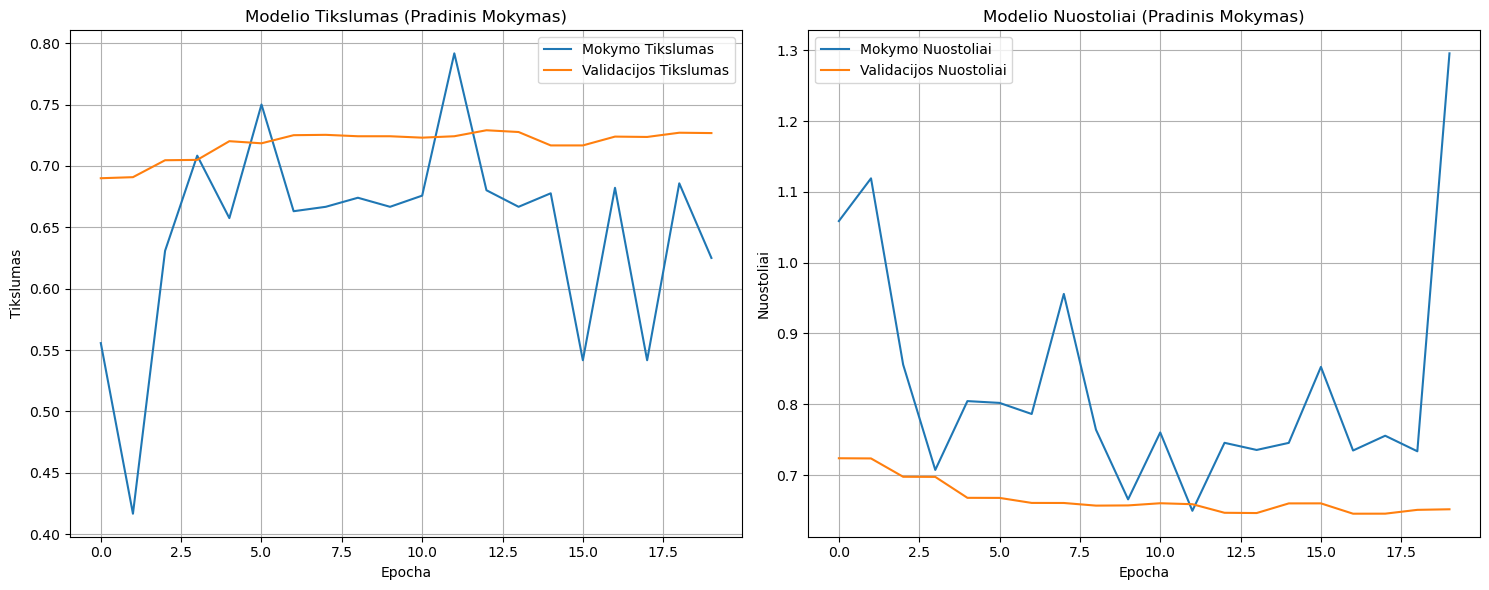

--- Pradinis Modelio Mokymas Baigtas (arba Praleistas) ---

--- Modelio Tikslinimo (Fine-tuning) Pradžia ---
Įkeliamas modelis iš best_galaxy_classifier_initial_224px_4class_balanced.keras tikslinimui.
Modelis tikslinimui sėkmingai įkeltas ir konfigūracija atitinka.
Tikslinama nuo bazinio modelio sluoksnio indekso 133 (atšildyta viršutiniai 30% sluoksnių).
Modelis perkompiliuotas tikslinimui.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avg_pool                        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout_1 (Dropout)         │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dense_1 (Dense)             │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ top_dropout_2 (Dropout)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,090,372 (91.90 MB)

 Trainable params: 17,730,820 (67.64 MB)

 Non-trainable params: 6,359,552 (24.26 MB)

Tikslinama 15 epochų.
Epoch 1/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.6277 - loss: 0.8656  
Epoch 1: val_accuracy improved from -inf to 0.74023, saving model to best_galaxy_classifier_finetuned_224px_4class_balanced.keras
437/437 ━━━━━━━━━━━━━━━━━━━━ 201s 412ms/step - accuracy: 0.6278 - loss: 0.8654 - val_accuracy: 0.7402 - val_loss: 0.6080 - learning_rate: 1.0000e-05
Epoch 2/15
  1/437 ━━━━━━━━━━━━━━━━━━━━ 1:09 160ms/step - accuracy: 0.5833 - loss: 0.8608
Epoch 2: val_accuracy did not improve from 0.74023
437/437 ━━━━━━━━━━━━━━━━━━━━ 31s 70ms/step - accuracy: 0.5833 - loss: 0.8608 - val_accuracy: 0.7397 - val_loss: 0.6077 - learning_rate: 1.0000e-05
Epoch 3/15
437/437 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.7178 - loss: 0.6600  
Epoch 3: val_accuracy improved from 0.74023 to 0.74914, saving model to best_galaxy_classifier_finetuned_224px_4class_balanced.keras
437/437 ━━━━━━━━━━━━━━━━━━━━ 188s 429ms/step - accuracy: 0.7178 - loss: 0.6600 - val_accuracy: 0.7

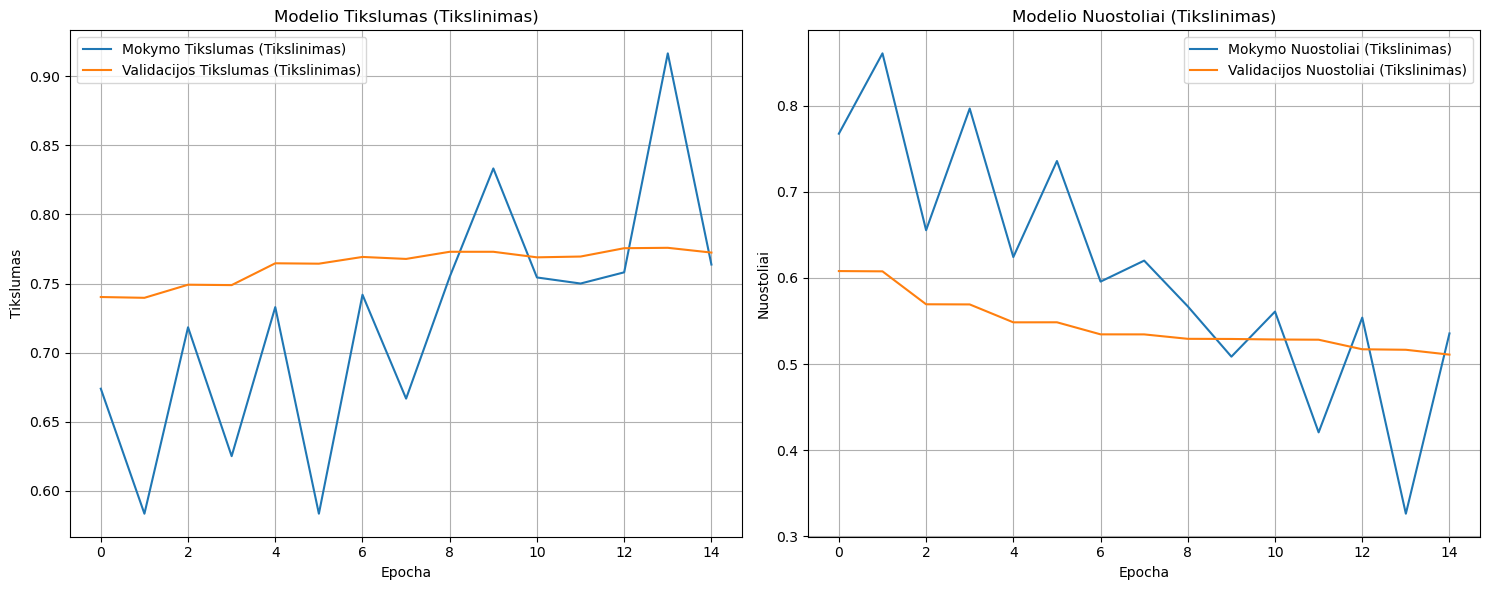

--- Modelio Tikslinimas Baigtas (arba Praleistas) ---


In [5]:
# ==============================================================================
# 6. MODELIO MOKYMAS (PRADINIS - TIK "GALVA")
# Naudojama EarlyStopping kantrybė 10.
# ==============================================================================
print("\n--- Modelio Mokymo Pradžia (Pradinis - Tik Galva) ---")
checkpoint_initial = ModelCheckpoint(
    MODEL_CHECKPOINT_PATH, monitor='val_accuracy', save_best_only=True, verbose=1, mode='max'
)
# EarlyStopping kantrybė nustatyta į 10 pradiniam mokymui.
early_stopping_initial = EarlyStopping(
    monitor='val_loss', patience=10, verbose=1, restore_best_weights=True
)
reduce_lr_initial = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1
)

steps_per_epoch = max(1, train_generator.samples // BATCH_SIZE) if train_generator else 0
validation_steps = max(1, validation_generator.samples // BATCH_SIZE) if validation_generator else 0

history_initial = None
if initial_model and train_generator and validation_generator and steps_per_epoch > 0 and validation_steps > 0:
    print(f"Mokoma su: Žingsnių per epochą: {steps_per_epoch}, Validacijos žingsnių: {validation_steps}")
    print(f"Naudojami klasių svoriai: {class_weights if class_weights else 'Nėra'}")
    history_initial = initial_model.fit(
        train_generator, epochs=EPOCHS, initial_epoch=0, validation_data=validation_generator,
        steps_per_epoch=steps_per_epoch, validation_steps=validation_steps,
        callbacks=[checkpoint_initial, early_stopping_initial, reduce_lr_initial],
        class_weight=class_weights if class_weights else None, verbose=1
    )
    if history_initial:
        print("\nPiešiama pradinio mokymo istorija...")
        plt.figure(figsize=(15, 6)); plt.subplot(1, 2, 1)
        plt.plot(history_initial.history['accuracy'], label='Mokymo Tikslumas')
        plt.plot(history_initial.history['val_accuracy'], label='Validacijos Tikslumas')
        plt.title('Modelio Tikslumas (Pradinis Mokymas)'); plt.xlabel('Epocha'); plt.ylabel('Tikslumas'); plt.legend(); plt.grid(True)
        plt.subplot(1, 2, 2)
        plt.plot(history_initial.history['loss'], label='Mokymo Nuostoliai')
        plt.plot(history_initial.history['val_loss'], label='Validacijos Nuostoliai')
        plt.title('Modelio Nuostoliai (Pradinis Mokymas)'); plt.xlabel('Epocha'); plt.ylabel('Nuostoliai'); plt.legend(); plt.grid(True)
        plt.tight_layout(); plt.show()
else:
    print("KLAIDA: Mokymo sąlygos netenkintos. Praleidžiamas pradinis mokymas.")
    # ... (detalesni klaidų pranešimai gali būti čia) ...
print("--- Pradinis Modelio Mokymas Baigtas (arba Praleistas) ---")


# ==============================================================================
# 7. MODELIO TIKSLINIMAS (FINE-TUNING)
# Atšildoma dalis bazinio modelio ir tęsiamas mokymas su mažesniu mokymosi greičiu.
# EarlyStopping kantrybė nustatyta į 5 tikslinimui.
# ==============================================================================
print("\n--- Modelio Tikslinimo (Fine-tuning) Pradžia ---")
FINE_TUNE_EPOCHS = 15
FINE_TUNE_LEARNING_RATE = LEARNING_RATE / 10
UNFREEZE_PERCENT = 0.3

fine_tune_model = None
if os.path.exists(MODEL_CHECKPOINT_PATH):
    print(f"Įkeliamas modelis iš {MODEL_CHECKPOINT_PATH} tikslinimui.")
    try:
        fine_tune_model = tf.keras.models.load_model(MODEL_CHECKPOINT_PATH)
        # Patikriname, ar įkelto modelio konfigūracija atitinka dabartinę
        if fine_tune_model.input_shape[1:3] != (IMG_WIDTH, IMG_HEIGHT) or \
           fine_tune_model.output_shape[-1] != NUM_CLASSES:
            print("PERSPĖJIMAS: Įkelto modelio konfigūracija (įvestis/išvestis) nesutampa su dabartine "
                  "skirta tikslinimui. Tikslinimas gali būti neteisingas arba praleistas.")
            # Galima būtų bandyti sukurti naują modelį, bet tai reikštų, kad pradinio mokymo etapas buvo su kitais parametrais.
            # Šiuo atveju, jei nesutampa, tikslinimas nebus vykdomas teisingai su šiuo modeliu.
            # Saugiausia būtų praleisti tikslinimą arba užtikrinti, kad MODEL_CHECKPOINT_PATH yra teisingas.
            fine_tune_model = None # Neleisime tikslinti nesuderinamo modelio.
        else:
             print("Modelis tikslinimui sėkmingai įkeltas ir konfigūracija atitinka.")

    except Exception as e:
        print(f"Klaida įkeliant modelį tikslinimui: {e}")
        fine_tune_model = None
else:
    print(f"KLAIDA: Modelio kontrolinis taškas {MODEL_CHECKPOINT_PATH} nerastas. Negalima tikslinti.")

if fine_tune_model:
    if len(fine_tune_model.layers) > 1 and isinstance(fine_tune_model.layers[1], tf.keras.Model):
        base_model_to_fine_tune = fine_tune_model.layers[1]
        base_model_to_fine_tune.trainable = True
        num_base_layers = len(base_model_to_fine_tune.layers)
        fine_tune_from_layer_index = int(num_base_layers * (1 - UNFREEZE_PERCENT))
        print(f"Tikslinama nuo bazinio modelio sluoksnio indekso {fine_tune_from_layer_index} "
              f"(atšildyta viršutiniai {int(UNFREEZE_PERCENT*100)}% sluoksnių).")

        for layer_idx, layer in enumerate(base_model_to_fine_tune.layers):
            layer.trainable = (layer_idx >= fine_tune_from_layer_index)

        fine_tune_model.compile(optimizer=Adam(learning_rate=FINE_TUNE_LEARNING_RATE),
                                  loss='categorical_crossentropy', metrics=['accuracy'])
        print("Modelis perkompiliuotas tikslinimui.")
        fine_tune_model.summary()

        ft_checkpoint = ModelCheckpoint(FINE_TUNED_MODEL_CHECKPOINT_PATH, monitor='val_accuracy', save_best_only=True, verbose=1, mode='max')
        # EarlyStopping kantrybė nustatyta į 5 tikslinimui.
        ft_early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
        ft_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)

        print(f"Tikslinama {FINE_TUNE_EPOCHS} epochų.")
        history_fine_tune = fine_tune_model.fit(
            train_generator, epochs=FINE_TUNE_EPOCHS, initial_epoch=0, validation_data=validation_generator,
            steps_per_epoch=steps_per_epoch, validation_steps=validation_steps,
            callbacks=[ft_checkpoint, ft_early_stopping, ft_reduce_lr],
            class_weight=class_weights if class_weights else None
        )
        if history_fine_tune:
            print("\nPiešiama tikslinimo mokymo istorija...")
            plt.figure(figsize=(15, 6)); plt.subplot(1, 2, 1)
            plt.plot(history_fine_tune.history['accuracy'], label='Mokymo Tikslumas (Tikslinimas)')
            plt.plot(history_fine_tune.history['val_accuracy'], label='Validacijos Tikslumas (Tikslinimas)')
            plt.title('Modelio Tikslumas (Tikslinimas)'); plt.xlabel('Epocha'); plt.ylabel('Tikslumas'); plt.legend(); plt.grid(True)
            plt.subplot(1, 2, 2)
            plt.plot(history_fine_tune.history['loss'], label='Mokymo Nuostoliai (Tikslinimas)')
            plt.plot(history_fine_tune.history['val_loss'], label='Validacijos Nuostoliai (Tikslinimas)')
            plt.title('Modelio Nuostoliai (Tikslinimas)'); plt.xlabel('Epocha'); plt.ylabel('Nuostoliai'); plt.legend(); plt.grid(True)
            plt.tight_layout(); plt.show()
    else:
        print("KLAIDA: Nepavyko identifikuoti bazinio modelio sluoksnio tikslinimui.")
else:
     print("Tikslinimas praleistas, nes pradinis modelis negalėjo būti įkeltas arba jo konfigūracija netiko.")
print("--- Modelio Tikslinimas Baigtas (arba Praleistas) ---")

In [5]:
# ==============================================================================
# 8. MODELIO VERTINIMAS TESTAVIMO AIBĖJE
# Vertinamas geriausias modelis (tikslintas arba pradinis) testavimo aibėje.
# ==============================================================================
print("\n--- Modelio Vertinimas Testavimo Aibėje ---")
from sklearn.metrics import classification_report, confusion_matrix

best_model_to_evaluate = None
evaluation_model_path = ""
model_type_for_evaluation = "Nenustatytas" # Kintamasis, nurodantis, kuris modelis vertinamas

if os.path.exists(FINE_TUNED_MODEL_CHECKPOINT_PATH):
    print(f"Bandoma įkelti TIKSLINTĄ modelį iš: {FINE_TUNED_MODEL_CHECKPOINT_PATH}")
    evaluation_model_path = FINE_TUNED_MODEL_CHECKPOINT_PATH
    model_type_for_evaluation = "Tikslintas"
elif os.path.exists(MODEL_CHECKPOINT_PATH):
    print(f"Tikslintas modelis nerastas. Bandoma įkelti PRADINĮ modelį iš: {MODEL_CHECKPOINT_PATH}")
    evaluation_model_path = MODEL_CHECKPOINT_PATH
    model_type_for_evaluation = "Pradinis"
else:
    print("KLAIDA: Nerasta nei pradinio, nei tikslinto modelio kontrolinio taško. Negalima vertinti.")

if evaluation_model_path:
    try:
        best_model_to_evaluate = tf.keras.models.load_model(evaluation_model_path)
        print(f"Modelis ({model_type_for_evaluation}) sėkmingai įkeltas iš {evaluation_model_path} vertinimui.")
        # Papildomas patikrinimas, ar įkelto modelio konfigūracija atitinka dabartinę (ypač svarbu, jei keitėsi NUM_CLASSES)
        if best_model_to_evaluate.output_shape[-1] != NUM_CLASSES:
            print(f"KRITINIS PERSPĖJIMAS: Įkelto modelio ({model_type_for_evaluation}) klasių skaičius ({best_model_to_evaluate.output_shape[-1]}) "
                  f"nesutampa su dabartiniu NUM_CLASSES ({NUM_CLASSES}). Vertinimo rezultatai gali būti klaidinantys.")
    except Exception as e:
        print(f"Klaida įkeliant modelį ({model_type_for_evaluation}) iš {evaluation_model_path}: {e}")
        best_model_to_evaluate = None # Svarbu nustatyti None, jei nepavyko

if test_generator and best_model_to_evaluate:
    test_steps = max(1, (test_generator.samples + BATCH_SIZE - 1) // BATCH_SIZE)
    print(f"Vertinamas {model_type_for_evaluation} modelis su test_steps: {test_steps}")
    test_loss, test_accuracy = best_model_to_evaluate.evaluate(test_generator, steps=test_steps, verbose=1)
    print(f"\nTestavimo Nuostoliai ({model_type_for_evaluation} modelis): {test_loss:.4f}")
    print(f"Testavimo Tikslumas ({model_type_for_evaluation} modelis): {test_accuracy:.4f}")

    print("\nGeneruojama klasifikavimo ataskaita ir painiavos matrica...")
    predictions = best_model_to_evaluate.predict(test_generator, steps=test_steps, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())
    num_samples_for_report = min(len(true_classes), len(predicted_classes))

    report = classification_report(
        true_classes[:num_samples_for_report], predicted_classes[:num_samples_for_report],
        target_names=class_labels, zero_division=0
    )
    print(f"\nKlasifikavimo Ataskaita ({model_type_for_evaluation} modelis):")
    print(report)

    cm = confusion_matrix(true_classes[:num_samples_for_report], predicted_classes[:num_samples_for_report])
    plt.figure(figsize=(10, 8)) # Sumažintas dydis, kad tilptų į standartinį Jupyter langą
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Painiavos Matrica ({model_type_for_evaluation} modelis)')
    plt.xlabel('Prognozuota Etiketė'); plt.ylabel('Tikroji Etiketė'); plt.show()
elif not best_model_to_evaluate:
    print("KLAIDA: Modelis nepasiekiamas vertinimui.")
else:
    print("KLAIDA: Testavimo generatorius nepasiekiamas. Praleidžiamas vertinimas.")
print("\n--- Galaktikų Klasifikavimo Užduotis Baigta ---")


--- Modelio Vertinimas Testavimo Aibėje ---
Bandoma įkelti TIKSLINTĄ modelį iš: models/best_galaxy_classifier_finetuned_224px_4class_balanced.keras
Modelis (Tikslintas) sėkmingai įkeltas iš models/best_galaxy_classifier_finetuned_224px_4class_balanced.keras vertinimui.
Klaida įkeliant modelį (Tikslintas) iš models/best_galaxy_classifier_finetuned_224px_4class_balanced.keras: name 'NUM_CLASSES' is not defined


NameError: name 'test_generator' is not defined

In [ ]:
# ==============================================================================
# 9. PAVYZDINIŲ PROGNOZIŲ RODYMAS
# Rodomos kelios nuotraukos su tikrosiomis ir prognozuotomis etiketėmis.
# Modifikuota, kad prognozuotų po vieną nuotrauką, siekiant išvengti atminties klaidų.
# ==============================================================================
print("\n--- Pavyzdinių Prognozių Rodymas (Prognozuojama po vieną nuotrauką) ---")

# --- Konfigūracija Rodymui ---
NUM_IMAGES_TO_DISPLAY_VISUALIZATION = 25 # Kiek nuotraukų rodyti iš viso
FIG_SIZE_WIDTH = 15
FIG_SIZE_HEIGHT = 15
# --- Įkeliame geriausią modelį (tikslintą, jei yra, kitaip pradinį) ---
display_model_path_final = ""
model_type_for_display = "Nenustatytas"
if os.path.exists(FINE_TUNED_MODEL_CHECKPOINT_PATH):
    display_model_path_final = FINE_TUNED_MODEL_CHECKPOINT_PATH
    model_type_for_display = "Tikslintas"
elif os.path.exists(MODEL_CHECKPOINT_PATH):
    display_model_path_final = MODEL_CHECKPOINT_PATH
    model_type_for_display = "Pradinis"

evaluation_model_for_display = None
if display_model_path_final:
    print(f"Įkeliamas {model_type_for_display} modelis prognozių rodymui iš: {display_model_path_final}")
    try:
        evaluation_model_for_display = tf.keras.models.load_model(display_model_path_final)
        print("Modelis sėkmingai įkeltas.")
    except Exception as e:
        print(f"Klaida įkeliant modelį: {e}. Negalima rodyti prognozių.")
else:
    print("Nerasta modelio kontrolinio taško. Negalima rodyti prognozių.")

if evaluation_model_for_display and 'test_generator' in locals() and test_generator is not None:
    test_generator.reset() # Svarbu atstatyti generatorių
    
    # Sukursime sąrašus nuotraukoms, tikroms ir prognozuotoms etiketėms kaupti
    images_to_plot = []
    true_indices_to_plot = []
    predicted_indices_to_plot = []
    
    print(f"Gaunamos ir prognozuojamos nuotraukos po vieną (iki {NUM_IMAGES_TO_DISPLAY_VISUALIZATION} vnt.)...")
    
    try:
        for i in range(NUM_IMAGES_TO_DISPLAY_VISUALIZATION):
            # Gauname kitą porciją iš generatoriaus.
            # Nors generatorius duoda visą porciją, mes naudosime tik pirmą nuotrauką iš jos.
            images_batch, true_labels_one_hot_batch = next(test_generator)
            
            if images_batch.shape[0] == 0: # Jei generatorius baigėsi anksčiau
                print(f"Generatorius baigėsi anksčiau, surinkta tik {len(images_to_plot)} nuotraukų.")
                break
                
            # Paimame pirmą nuotrauką ir jos etiketę iš porcijos
            current_image = images_batch[0:1] # Svarbu palikti kaip batch su 1 elementu [1, H, W, C]
            current_true_label_one_hot = true_labels_one_hot_batch[0:1]
            
            # Vykdome prognozę tik vienai nuotraukai
            prediction = evaluation_model_for_display.predict(current_image, verbose=0) # verbose=0, kad nebūtų progreso juostos kiekvienai nuotraukai
            
            # Išsaugome rezultatus
            images_to_plot.append(current_image[0]) # Išimame iš batch dimensijos
            true_indices_to_plot.append(np.argmax(current_true_label_one_hot, axis=1)[0])
            predicted_indices_to_plot.append(np.argmax(prediction, axis=1)[0])
            
            if (i + 1) % 5 == 0: # Kas 5 nuotraukas išvedame pranešimą
                 print(f"  Apdorota {i+1}/{NUM_IMAGES_TO_DISPLAY_VISUALIZATION} nuotraukų...")

    except StopIteration:
        print(f"Generatorius baigėsi anksčiau (StopIteration), surinkta tik {len(images_to_plot)} nuotraukų.")
        # Tai normalu, jei test_generator turi mažiau pavyzdžių nei NUM_IMAGES_TO_DISPLAY_VISUALIZATION * test_generator.batch_size
        # arba jei NUM_IMAGES_TO_DISPLAY_VISUALIZATION yra didesnis nei test_generator.samples

    num_actually_plotted = len(images_to_plot)

    if num_actually_plotted > 0:
        idx_to_class = {v: k for k, v in test_generator.class_indices.items()}
        print(f"\nPiešiamos {num_actually_plotted} nuotraukos su {model_type_for_display} modelio prognozėmis...")
        
        cols = int(np.ceil(np.sqrt(num_actually_plotted)))
        rows = (num_actually_plotted + cols - 1) // cols
        
        plt.figure(figsize=(FIG_SIZE_WIDTH, FIG_SIZE_HEIGHT))
        for i in range(num_actually_plotted):
            plt.subplot(rows, cols, i + 1)
            plt.imshow(images_to_plot[i])
            true_label_name = idx_to_class.get(true_indices_to_plot[i], "Nežinoma")
            predicted_label_name = idx_to_class.get(predicted_indices_to_plot[i], "Nežinoma")
            title_color = 'green' if true_indices_to_plot[i] == predicted_indices_to_plot[i] else 'red'
            plt.title(f"Tikra: {true_label_name}\nPrognozė: {predicted_label_name}", color=title_color, fontsize=9)
            plt.axis('off')
        plt.tight_layout(); plt.show()
    else:
        print("Klaida: Nepavyko surinkti nuotraukų rodymui.")

elif not evaluation_model_for_display:
    print("Praleidžiamas prognozių rodymas, nes modelis negalėjo būti įkeltas.")
else:
    print("Praleidžiamas prognozių rodymas, nes 'test_generator' nepasiekiamas.")
print("\n--- Prognozių Rodymas Baigtas ---")